<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# Pyspark TensorFlow Inference

### Text Classification
In this notebook, we demonstrate training a model to perform sentiment analysis, and using the trained model for distributed inference.  
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

Note that cuFFT/cuDNN/cuBLAS registration errors are expected (as of `tf=2.17.0`) and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  

In [1]:
import os
import re
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses

2025-01-07 17:55:03.625173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 17:55:03.632499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 17:55:03.640392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 17:55:03.642797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:55:03.648973: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.17.0


### Download and explore the dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("imdb")

In [4]:
# Create directories for our data
base_dir = "spark-dl-datasets/imdb"
if os.environ.get("DATABRICKS_RUNTIME_VERSION", False):
    # For databricks, use the driver disk rather than Workspace (much faster)
    base_dir = "/local_disk0/" + base_dir

train_dir = base_dir / "train"
test_dir = base_dir / "test"

In [5]:
# Create directories for positive (1) and negative (0) reviews
for split in ["train", "test"]:
    split_dir = base_dir / split
    pos_dir = split_dir / "pos"
    neg_dir = split_dir / "neg"

    os.makedirs(pos_dir, exist_ok=True)
    os.makedirs(neg_dir, exist_ok=True)

In [6]:
def write_reviews_to_files(dataset_split, split_name):
    for idx, example in enumerate(dataset_split):
        label_dir = "pos" if example["label"] == 1 else "neg"
        dir_path = base_dir / split_name / label_dir

        file_path = dir_path / f"review_{idx}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(example["text"])

# Write train and test sets
write_reviews_to_files(dataset["train"], "train")
write_reviews_to_files(dataset["test"], "test")

There are 25,000 examples in the training folder, of which we will use 80% (or 20,000) for training, and 5,000 for validation.

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    str(train_dir),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    str(train_dir),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    str(test_dir),
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2025-01-07 17:55:15.035387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45468 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


We can take a look at a sample of the dataset:

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'I was really, really disappointed with this movie. it started really well, and built up some great atmosphere and suspense, but when it finally got round to revealing the "monster"...it turned out to be just some psycho with skin problems......again. Whoop-de-do. Yet another nutjob movie...like we don\'t already have enough of them.<br /><br />To be fair, the "creep" is genuinely unsettling to look at, and the way he moves and the strange sounds he makes are pretty creepy, but I\'m sick of renting film like this only to discover that the monster is human, albeit a twisted, demented, freakish one. When I saw all the tell-tale rats early on I was hoping for some kind of freaky rat-monster hybrid thing...it was such a let down when the Creep was revealed.<br /><br />On top of this, some of the stuff in this movie makes no sense. (Spoiler) <br /><br />Why the hell does the Creep kill the security Guard? Whats the point, apart from sticking a great honking sign up that says "HI I\'

2025-01-07 17:55:21.572943: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice the reviews contain raw text (with punctuation and occasional HTML tags like \<br/>\). We will show how to handle these in the following section.

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


### Prepare the dataset for training

Next, we will standardize, tokenize, and vectorize the data using the tf.keras.layers.TextVectorization layer.  
We will write a custom standardization function to remove the HTML.

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

Next, we will create a TextVectorization layer to standardize, tokenize, and vectorize our data.

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [12]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2025-01-07 17:55:35.387277: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's create a function to see the result of using this layer to preprocess some data.

In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"To describe this film as garbage is unfair. At least rooting through garbage can be an absorbing hobby. This flick was neither absorbing nor entertaining.<br /><br />Kevin Bacon can act superbly given the chance, so no doubt had an IRS bill to settle when he agreed to this dire screenplay. The mad scientist story of 'Hollow Man' has been told before, been told better, and been told without resorting to so many ludicrously expensive special effects.<br /><br />Most of those special effects seem to be built around the transparent anatomical dolls of men, women and dogs you could buy in the early seventies. In the UK they were marketed as 'The Transparent Man (/Woman/Dog)' which is maybe where they got the title for this film.<br /><br />Clever special effects, dire script, non-existent plot.<br /><br />", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   6, 1507,   11,   19,   14, 1184,    7, 5230,   30,  21

We can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [15]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  nowhere
 313 --->  house
Vocabulary size: 10000


In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [18]:
embedding_dim = 16

In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

#### Train model

In [21]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1736272546.613950 3675377 service.cc:146] XLA service 0x70ca64001f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736272546.613963 3675377 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-07 17:55:46.627250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-07 17:55:46.680543: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 89/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5183 - loss: 0.6920

I0000 00:00:1736272547.264048 3675377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5778 - loss: 0.6821 - val_binary_accuracy: 0.7072 - val_loss: 0.6182
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.7568 - loss: 0.5817 - val_binary_accuracy: 0.8002 - val_loss: 0.4987
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - binary_accuracy: 0.8323 - loss: 0.4656 - val_binary_accuracy: 0.8352 - val_loss: 0.4233
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - binary_accuracy: 0.8535 - loss: 0.3954 - val_binary_accuracy: 0.8520 - val_loss: 0.3789
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - binary_accuracy: 0.8708 - loss: 0.3502 - val_binary_accuracy: 0.8590 - val_loss: 0.3506
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - binary_accuracy: 0.8805 - loss: 0.3183 - val_binary_accuracy: 0.8668 - val_loss: 0.3309
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - binary_accuracy: 0.8908 - loss: 0.2935 - val_binary_accuracy: 0.8698 - val_loss: 0.3170
Epoch

#### Evaluate the model

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - binary_accuracy: 0.8727 - loss: 0.3141
Loss:  0.3163740932941437
Accuracy:  0.8708400130271912


Create a plot of accuracy and loss over time:

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

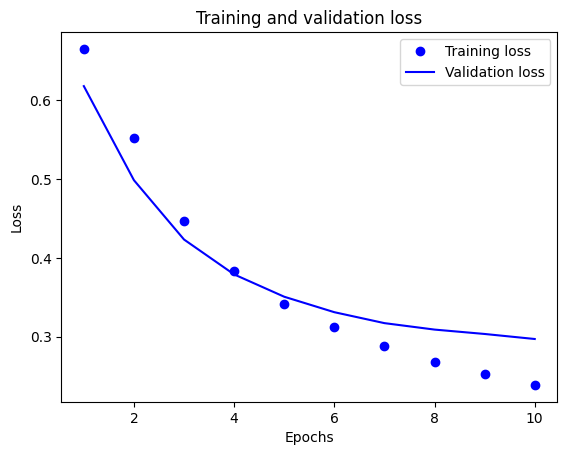

In [24]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

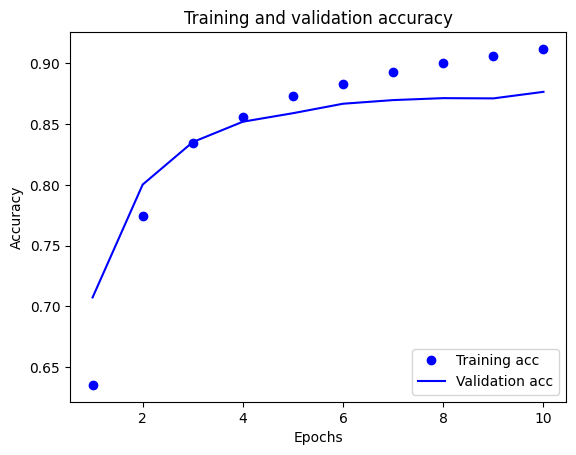

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model

We can export the model including the TextVectorization layer inside the model to conduct inference on raw text.

In [26]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4957 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5, 'binary_accuracy': 0.0, 'loss': 0.0}


Conduct inference on new data:

In [27]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[0.6689762 ],
       [0.62865674],
       [0.6049684 ]], dtype=float32)

### Save Model

In [28]:
os.mkdir('models') if not os.path.exists('models') else None

In [29]:
export_model.save('models/text_model.keras')

### Load model

In [30]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('models/text_model.keras', compile=False)

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       160,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

### Predict

In [31]:
new_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.6689762 ],
       [0.62865674],
       [0.6049684 ]], dtype=float32)

## PySpark

In [32]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array, pandas_udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pandas as pd
import json

Check the cluster environment to handle any platform-specific Spark configurations.

In [36]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_IMAGE_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

#### Create Spark Session

For local standalone clusters, we'll connect to the cluster and create the Spark Session.  
For CSP environments, Spark will either be preconfigured (Databricks) or we'll need to create the Spark Session (Dataproc).

In [37]:
conf = SparkConf()

if 'spark' not in globals():
    if on_standalone:
        import socket
        
        conda_env = os.environ.get("CONDA_PREFIX")
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
        # Point PyTriton to correct libpython3.11.so:
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_env}/lib:{conda_env}/lib/python3.11/site-packages/nvidia_pytriton.libs:$LD_LIBRARY_PATH")
        source = "/usr/lib/x86_64-linux-gnu/libstdc++.so.6"
        target = f"{conda_env}/lib/libstdc++.so.6"
        try:
            if os.path.islink(target) or os.path.exists(target):
                os.remove(target)
            os.symlink(source, target)
        except OSError as e:
            print(f"Error creating symlink: {e}")
    elif on_dataproc:
        # Point PyTriton to correct libpython3.11.so:
        conda_lib_path="/opt/conda/miniconda3/lib"
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_lib_path}:$LD_LIBRARY_PATH")
        conf.set("spark.executorEnv.TF_GPU_ALLOCATOR", "cuda_malloc_async")
        conf.set("spark.executor.instances", "4") # dataproc defaults to 2

    conf.set("spark.executor.cores", "8")
    conf.set("spark.task.resource.gpu.amount", "0.125")
    conf.set("spark.executor.resource.gpu.amount", "1")
    conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    conf.set("spark.python.worker.reuse", "true")

conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

25/01/06 22:02:26 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
25/01/06 22:02:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/06 22:02:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load the IMDB dataset. We'll perform inference on the first sentence of each sample.

In [38]:
from datasets import load_dataset

dataset = load_dataset("imdb", split="test")
dataset = dataset.to_pandas().drop(columns="label")

#### Create PySpark DataFrame

In [39]:
df = spark.createDataFrame(dataset).repartition(8)
df.schema

StructType([StructField('text', StringType(), True)])

In [40]:
df.take(1)

25/01/06 22:02:35 WARN TaskSetManager: Stage 0 contains a task of very large size (4021 KiB). The maximum recommended task size is 1000 KiB.


[Row(text="Anyone remember the first CKY, CKY2K etc..? Back when it was about making crazy cool stuff, rather than watching Bam Margera act like a douchebag, spoiled 5 year old, super/rock-star wannabe.<br /><br />The show used to be awesome, however, Bam's fame and wealth has led him to believe, that we now enjoy him acting childish and idiotic, more than actual cool stuff, that used to be in ex. CKY2K.<br /><br />The acts are so repetitive, there's like nothing new, except annoying stupidity and rehearsed comments... The only things we see is Bam Margera, so busy showing us how much he doesn't care, how much money he got or whatsoever.<br /><br />I really got nothing much left to say except, give us back CKY2K, cause Bam suck..<br /><br />I enjoy watching Steve-o, Knoxville etc. a thousand times more.")]

In [41]:
data_path = "spark-dl-datasets/imdb_test"
if on_databricks:
    data_path = "dbfs:/FileStore/" + data_path

df.write.mode("overwrite").parquet(data_path)

25/01/06 22:02:36 WARN TaskSetManager: Stage 3 contains a task of very large size (4021 KiB). The maximum recommended task size is 1000 KiB.


#### Load and Preprocess PySpark DataFrame

Define our preprocess function. We'll take the first sentence of each sample as our input for sentiment analysis.

In [42]:
@pandas_udf("string")
def preprocess(text: pd.Series) -> pd.Series:
    return pd.Series([s.split(".")[0] for s in text])

In [43]:
df = spark.read.parquet(data_path).limit(512).repartition(8)

In [44]:
input_df = df.select(preprocess(col("text")).alias("lines")).cache()

## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/3.4.0/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses Tensorflow APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

In [45]:
text_model_path = "{}/models/text_model.keras".format(os.getcwd())

# For cloud environments, copy the model to the distributed file system.
if on_databricks:
    import shutil
    dbutils.fs.mkdirs("/FileStore/spark-dl-models")
    dbfs_model_path = "/dbfs/FileStore/spark-dl-models/text_model.keras"
    shutil.copy(text_model_path, dbfs_model_path)
    text_model_path = dbfs_model_path

In [46]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(text_model_path)

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [47]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [48]:
%%time
predictions = input_df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 5.29 ms, sys: 4.43 ms, total: 9.73 ms
Wall time: 4.3 s


In [49]:
%%time
predictions = input_df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 4.94 ms, sys: 0 ns, total: 4.94 ms
Wall time: 150 ms


In [50]:
%%time
predictions = input_df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 2.38 ms, sys: 2.54 ms, total: 4.92 ms
Wall time: 206 ms


In [51]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|The only reason I'm even giving this movie a 4 is because it was made in to a...|0.52321863|
|Awkward disaster mishmash has a team of scavengers coming across the overturn...|0.55067354|
|Here is a fantastic concept for a film - a series of meteors crash into a sma...| 0.6197893|
|              I walked out of the cinema having suffered this film after 30 mins| 0.5503541|
|A wildly uneven film where the major problem is the uneasy mix of comedy and ...| 0.5540192|
|Leonard Rossiter and Frances de la Tour carry this film, not without a strugg...| 0.5467422|
|                                                                     A good cast| 0.5688838|
|Yet again, I appear to be the only person on planet Earth w

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-pytriton.png" alt="drawing" width="700"/>

First we'll cleanup the vocabulary layer of the model to remove non-ASCII characters. This ensures the inputs can be properly serialized and sent to Triton.

In [52]:
import unicodedata

def normalize_vocabulary(vocab):
    # Normalize each word in the vocabulary to remove non-ASCII characters
    normalized_vocab = [
        unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8')
        for word in vocab
    ]
    normalized_vocab = filter(lambda x: x != '', normalized_vocab)
    normalized_vocab = list(set(normalized_vocab)) 


    return normalized_vocab

vocab = vectorize_layer.get_vocabulary()
normalized_vocab = normalize_vocabulary(vocab)

# Reassign the cleaned vocabulary to the TextVectorization layer
vectorize_layer.set_vocabulary(normalized_vocab)

In [53]:
# Save the model with the cleaned vocabulary
triton_model_path = '{}/models/text_model_cleaned.keras'.format(os.getcwd())
export_model.save(triton_model_path)

# For cloud environments, copy the model to the distributed file system.
if on_databricks:
    import shutil
    dbutils.fs.mkdirs("/FileStore/spark-dl-models")
    dbfs_model_path = "/dbfs/FileStore/spark-dl-models/text_model_cleaned.keras"
    shutil.copy(triton_model_path, dbfs_model_path)
    triton_model_path = dbfs_model_path

In [54]:
from functools import partial

In [55]:
def triton_server(ports, model_path):
    import time
    import signal
    import numpy as np
    import tensorflow as tf
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton, TritonConfig
    from pyspark import TaskContext
    from tensorflow.keras import layers 

    
    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                "custom_standardization": custom_standardization}

    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(model_path)

    @batch
    def _infer_fn(**inputs):
        sentences = inputs["text"]
        print(f"SERVER: Received batch of size {len(sentences)}.")
        decoded_sentences = tf.convert_to_tensor(np.vectorize(lambda x: x.decode('utf-8'))(sentences))
        return {
            "preds": model.predict(decoded_sentences)
        }
    
    workspace_path = f"/tmp/triton_{time.strftime('%m_%d_%M_%S')}"
    triton_conf = TritonConfig(http_port=ports[0], grpc_port=ports[1], metrics_port=ports[2])
    with Triton(config=triton_conf, workspace=workspace_path) as triton:
        triton.bind(
            model_name="TextModel",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="text", dtype=np.bytes_, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="preds", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=128,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def stop_triton(signum, frame):
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

def start_triton(ports, model_name, model_path):
    import socket
    from multiprocessing import Process
    from pytriton.client import ModelClient

    hostname = socket.gethostname()
    process = Process(target=triton_server, args=(ports, model_path,))
    process.start()

    client = ModelClient(f"http://localhost:{ports[0]}", model_name)
    patience = 10
    while patience > 0:
        try:
            client.wait_for_model(6)
            return [(hostname, process.pid)]
        except Exception:
            print("Waiting for server to be ready...")
            patience -= 1

    emsg = "Failure: client waited too long for server startup. Check the executor logs for more info."
    raise TimeoutError(emsg)
    print(emsg)
    return [(hostname, emsg)]

#### Start Triton servers

To ensure that only one Triton inference server is started per node, we use stage-level scheduling to delegate each task to a separate GPU.  

In [56]:
def _use_stage_level_scheduling(spark, rdd):

    if spark.version < "3.4.0":
        raise Exception("Stage-level scheduling is not supported in Spark < 3.4.0")

    executor_cores = spark.conf.get("spark.executor.cores")
    assert executor_cores is not None, "spark.executor.cores is not set"
    executor_gpus = spark.conf.get("spark.executor.resource.gpu.amount")
    assert executor_gpus is not None and int(executor_gpus) <= 1, "spark.executor.resource.gpu.amount must be set and <= 1"

    from pyspark.resource.profile import ResourceProfileBuilder
    from pyspark.resource.requests import TaskResourceRequests

    spark_plugins = spark.conf.get("spark.plugins", " ")
    assert spark_plugins is not None
    spark_rapids_sql_enabled = spark.conf.get("spark.rapids.sql.enabled", "true")
    assert spark_rapids_sql_enabled is not None

    task_cores = (
        int(executor_cores)
        if "com.nvidia.spark.SQLPlugin" in spark_plugins
        and "true" == spark_rapids_sql_enabled.lower()
        else (int(executor_cores) // 2) + 1
    )

    task_gpus = 1.0
    treqs = TaskResourceRequests().cpus(task_cores).resource("gpu", task_gpus)
    rp = ResourceProfileBuilder().require(treqs).build
    print(f"Reqesting stage-level resources: (cores={task_cores}, gpu={task_gpus})")

    return rdd.withResources(rp)

**Specify the number of nodes in the cluster.**  
Following the README, the example standalone cluster uses 1 node. The example Databricks/Dataproc cluster scripts use 4 nodes by default. 

In [57]:
# Change based on cluster setup
num_nodes = 1 if on_standalone else 4

In [58]:
sc = spark.sparkContext
nodeRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
nodeRDD = _use_stage_level_scheduling(spark, nodeRDD)

Reqesting stage-level resources: (cores=5, gpu=1.0)


Triton occupies ports for HTTP requests, GRPC requests, and the metrics service.

In [59]:
def find_ports():
    import psutil
    
    ports = []
    conns = [conn.laddr.port for conn in psutil.net_connections(kind="inet")]
    i = 7000
    while len(ports) < 3:
        if i not in conns:
            ports.append(i)
        i += 1
    
    return ports

In [60]:
model_name = "TextModel"
ports = find_ports()
assert len(ports) == 3
print(f"Using ports {ports}")

Using ports [7000, 7001, 7002]


In [61]:
pids = nodeRDD.barrier().mapPartitions(lambda _: start_triton(ports, model_name, triton_model_path)).collectAsMap()
print("Triton Server PIDs:\n", json.dumps(pids, indent=4))

Triton Server PIDs:
 {
    "cb4ae00-lcedt": 2897388
}


#### Define client function

In [62]:
url = f"http://localhost:{ports[0]}"

In [63]:
def triton_fn(url, model_name, init_timeout_s):
    import numpy as np
    from pytriton.client import ModelClient

    print(f"CLIENT: Connecting to {model_name} at {url}")

    def infer_batch(inputs):
        with ModelClient(url, model_name, init_timeout_s=init_timeout_s) as client:
            encoded_inputs = np.vectorize(lambda x: x.encode("utf-8"))(inputs).astype(np.bytes_)
            encoded_inputs = np.expand_dims(encoded_inputs, axis=1)
            result_data = client.infer_batch(encoded_inputs)
            
            return result_data["preds"]
            
    return infer_batch

#### Load and preprocess DataFrame

In [64]:
df = spark.read.parquet(data_path).limit(512).repartition(8)

In [ ]:
input_df = df.select(preprocess(col("text")).alias("lines")).cache()

25/01/06 22:02:44 WARN CacheManager: Asked to cache already cached data.


In [66]:
classify = predict_batch_udf(partial(triton_fn, url=url, model_name="TextModel", init_timeout_s=600),
                             return_type=FloatType(),
                             batch_size=64)

In [67]:
%%time
predictions = input_df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 10.4 ms, sys: 7 ms, total: 17.4 ms
Wall time: 2.53 s


In [68]:
%%time
predictions = input_df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 2.59 ms, sys: 631 μs, total: 3.22 ms
Wall time: 214 ms


In [69]:
%%time
predictions = input_df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 288 μs, sys: 3.66 ms, total: 3.95 ms
Wall time: 245 ms


In [70]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|The only reason I'm even giving this movie a 4 is because it was made in to a...| 0.5441438|
|Awkward disaster mishmash has a team of scavengers coming across the overturn...|0.58016133|
|Here is a fantastic concept for a film - a series of meteors crash into a sma...|0.55131954|
|              I walked out of the cinema having suffered this film after 30 mins|  0.542057|
|A wildly uneven film where the major problem is the uneasy mix of comedy and ...| 0.5196002|
|Leonard Rossiter and Frances de la Tour carry this film, not without a strugg...|0.53112733|
|                                                                     A good cast| 0.5486873|
|Yet again, I appear to be the only person on planet Earth w

#### Stop Triton Server on each executor

In [71]:
def stop_triton(pids):
    import os
    import socket
    import signal
    import time 
    
    hostname = socket.gethostname()
    pid = pids.get(hostname, None)
    assert pid is not None, f"Could not find pid for {hostname}"
    
    for _ in range(5):
        try:
            os.kill(pid, signal.SIGTERM)
        except OSError:
            return [True]
        time.sleep(5)

    return [False]

shutdownRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
shutdownRDD = _use_stage_level_scheduling(spark, shutdownRDD)
shutdownRDD.barrier().mapPartitions(lambda _: stop_triton(pids)).collect()

Reqesting stage-level resources: (cores=5, gpu=1.0)


[True]

In [73]:
spark.stop()